In [ ]:
from google.colab import drive
import zipfile
import os
from os import listdir, path
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline
from matplotlib import pyplot
from sklearn import preprocessing
import keras
from keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense, Reshape
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
ROOT_DIR = '/tmp/valid'
image_size = (64,64)    #tamanho das imagens do resnet
images = []
labels = []
species = []
plants_df = []
categs_df = []

# Data Extraction

The first step is to load the dataset into Colab. For that we have the whole dataset in a GoogleDrive file.
First we authorize Colab to reach our GoogleDrive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Then we specify where the file is in our GoogleDrive and extract the files into a tmp file in Colab.

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/valid.zip', 'r') #no folder do notebook procurar o folder onde está o zip e copiar o caminho
zip_ref.extractall('/tmp')
zip_ref.close()

Lastly we can check the number of files in the tmp file, whose path is given by ROOT_DIR.

In [ ]:
len(os.listdir(ROOT_DIR))

38

#Data Treatment

Here we created two lists of lists (all_paths and all_labels) that have the paths for all the images and their corresponding labels.
These are organized so that every list inside the main list corresponds only to one label.

In [ ]:
all_paths = []
all_labels = []
labels_for_enc = []
plant_folders = listdir(ROOT_DIR)

for folder in plant_folders:
    plant_list_path = listdir(path.join(ROOT_DIR,folder))
    img_paths = []
    labels = []

    for img_dir in plant_list_path:
      img_path = path.join(ROOT_DIR, folder, img_dir)
      img_paths.append(img_path)             #list of paths for all images of that folder; list will later be used for all_paths; [path_image1, path_image2, path_image3, path_image4]
      
      specie = img_dir.split(' ')[0]         #specie of that image; 'tomato', 'blueberry', etc 
      label = img_dir.split(' ')[1]          #label of that image; 'black_rot', 'late_blight', 'healthy', etc
      labels.append(label.lower())           #list of labels for all images of that folder; list will later be used for all_labels; [label1, label1, label1, label1, label1]
      
    labels_for_enc.append(label.lower())     #list of all labels that will later be used to create an encoder
    all_paths.append(img_paths)              #list of lists with the paths of each image; each list has a collection of the paths of all images for one of the 38 folders; 38 lists inside one list; each list inside has different lengths; [[path_image1_label1, path_image2_label1, path_image3_label1], [path_image1_label2, path_image2_label2, path_image3_label2], [path_image1_label3, path_image2_label3, path_image3_label3]]
    all_labels.append(labels)                #list of lists with the labels of each image; each list has a collection of the labels of all images for one of the 38 folders; 38 lists inside one list; each list inside has different lengths; [[label1_image1, label1_image2, label1_image3], [label2_image1, label2_image2, label2_image3], [label3_image1, label3_image2, label3_image3]]

Now we can see how many paths (therefore images) we have for each label.

We will then have 38 lines, corresponding to each folder and in each we can see how many images there are.

We can also see the total of paths that we have, given by sum.

In [ ]:
sum = 0
for pth in all_paths:
  sum += len(pth)
  print(len(pth))
print('sum is: ', sum)

432
490
430
456
448
465
457
497
477
463
505
504
425
435
478
456
497
480
480
410
481
485
459
502
472
423
485
470
477
445
503
456
421
436
440
454
434
444
sum is:  17572


We can do the same for the labels.

Here we can check that the number of labels is the same as the paths for each folder and for the total (sum).

In [ ]:
sum=0
for lbl in all_labels:
  sum += len(lbl)
  print(len(lbl))
print('sum is: ', sum)

432
490
430
456
448
465
457
497
477
463
505
504
425
435
478
456
497
480
480
410
481
485
459
502
472
423
485
470
477
445
503
456
421
436
440
454
434
444
sum is:  17572


We can see the format of one of the positions inside one of the lists of all_paths.

In [ ]:
all_paths[16][200]

'/tmp/valid/Pepper_Bell Healthy/Pepper_Bell Healthy 296.jpg'

Because in each path we also have the label in the name, if we see the same position but this time in all_labels, we can check that these correspond to the same.

In [ ]:
all_labels[16][200]

'healthy'

Now we can evaluate the labels_for_enc list. This list will now help us to transform our labels from strings ('healthy', 'late_blight', 'mosaic_virus', etc) into intergers (0, 1, 2, etc).

First we can see all of the labels inside the list.

In [ ]:
labels_for_enc

['healthy',
 'yellow_leaf_curl_virus',
 'isariopsis_leaf_spot',
 'healthy',
 'mosaic_virus',
 'healthy',
 'target_spot',
 'black_rot',
 'common_rust',
 'late_blight',
 'healthy',
 'scab',
 'bacterial_spot',
 'two_spotted_spider_mite',
 'bacterial_spot',
 'healthy',
 'healthy',
 'early_blight',
 'black_measles',
 'gray_leaf_spot',
 'healthy',
 'early_blight',
 'bacterial_spot',
 'healthy',
 'black_rot',
 'healthy',
 'late_blight',
 'leaf_mold',
 'northern_leaf_blight',
 'healthy',
 'greening',
 'healthy',
 'powdery_mildew',
 'septoria_leaf_spot',
 'cedar_rust',
 'healthy',
 'powdery_mildew',
 'leaf_scorch']

We can also see how many labels there are. There should be the same as the number of folders that our data was organized into.

In [ ]:
len(labels_for_enc)

38

Now we can create a dictionary for these labels. The keys are the labels and the corresponding value is the atributted interger.

If the label already exists (because some diseases repeat over the plants, and for each we have a healthy folder), the number will only be updated.  

In [ ]:
labels_for_enc = np.unique(labels_for_enc)

In [ ]:
labels_for_enc

array(['bacterial_spot', 'black_measles', 'black_rot', 'cedar_rust',
       'common_rust', 'early_blight', 'gray_leaf_spot', 'greening',
       'healthy', 'isariopsis_leaf_spot', 'late_blight', 'leaf_mold',
       'leaf_scorch', 'mosaic_virus', 'northern_leaf_blight',
       'powdery_mildew', 'scab', 'septoria_leaf_spot', 'target_spot',
       'two_spotted_spider_mite', 'yellow_leaf_curl_virus'], dtype='<U23')

In [ ]:
encode = {}

for i, label in enumerate(labels_for_enc):
  encode[label] =  i

encode

{'bacterial_spot': 0,
 'black_measles': 1,
 'black_rot': 2,
 'cedar_rust': 3,
 'common_rust': 4,
 'early_blight': 5,
 'gray_leaf_spot': 6,
 'greening': 7,
 'healthy': 8,
 'isariopsis_leaf_spot': 9,
 'late_blight': 10,
 'leaf_mold': 11,
 'leaf_scorch': 12,
 'mosaic_virus': 13,
 'northern_leaf_blight': 14,
 'powdery_mildew': 15,
 'scab': 16,
 'septoria_leaf_spot': 17,
 'target_spot': 18,
 'two_spotted_spider_mite': 19,
 'yellow_leaf_curl_virus': 20}

In [ ]:
for i in encode:
  print(i)

bacterial_spot
black_measles
black_rot
cedar_rust
common_rust
early_blight
gray_leaf_spot
greening
healthy
isariopsis_leaf_spot
late_blight
leaf_mold
leaf_scorch
mosaic_virus
northern_leaf_blight
powdery_mildew
scab
septoria_leaf_spot
target_spot
two_spotted_spider_mite
yellow_leaf_curl_virus


In [ ]:
len(labels_for_enc)

21

Due to problems of running out of RAM available to us, we had to create batches to divide our data. Here we divided the data into 10 batches.

So we created two dictionaries, one for the paths of the images and one for the labels.

For each dictionary, the keys are the name of the batch (batch_1, batch_2, batch_3, etc) and the values correspond to the paths/label.

In [ ]:
num_batchs = 10
bts_paths = {}
bts_labels = {}

for i in range(1,num_batchs+1):
  word = f"batch_{i}"
  bts_paths[word] = []
  bts_labels[word] = []

print(bts_paths)
print(bts_labels)

{'batch_1': [], 'batch_2': [], 'batch_3': [], 'batch_4': [], 'batch_5': [], 'batch_6': [], 'batch_7': [], 'batch_8': [], 'batch_9': [], 'batch_10': []}
{'batch_1': [], 'batch_2': [], 'batch_3': [], 'batch_4': [], 'batch_5': [], 'batch_6': [], 'batch_7': [], 'batch_8': [], 'batch_9': [], 'batch_10': []}



For this we had to take into account that our data is organized, which means that the paths/labels are grouped. Therefore, we had to divide the data into the batches, so that each batch has aproximatelly 10% of each category.

We start with the dictionay for the paths.

In [ ]:
i = 0
for list_paths in all_paths:
  divided_list = [list(array) for array in np.array_split(np.array(list_paths), num_batchs)]
  for part in divided_list:
    bts_paths[list(bts_paths.keys())[i]] += part
    i+=1
  i=0

Now we can see the shape of the dictionary. We can check that for each key (batch) there are aproxitamelly the same number of paths.

In [ ]:
for b_path in list(bts_paths.keys()):
  print(b_path,len(bts_paths[b_path]))

batch_1 1773
batch_2 1771
batch_3 1768
batch_4 1765
batch_5 1761
batch_6 1754
batch_7 1750
batch_8 1745
batch_9 1743
batch_10 1742


Now we can do the same for the labels. Here we also encoded our labels by using the dictionary previosly created.

In [ ]:
i = 0
for label in all_labels:
  divided_list = [list(array) for array in np.array_split(np.array(label), num_batchs)]
  for part in divided_list:
    encoded_part = []
    for individual_label in part:
      encoded_label = encode[individual_label]
      encoded_part.append(encoded_label)
    bts_labels[list(bts_labels.keys())[i]] += encoded_part
    i+=1
  i=0

We can again see the number of labels in each key (batch) and check that they are the same as the dictionary of the paths.

In [ ]:
for b_label in list(bts_labels.keys()):
  print(b_label,len(bts_labels[b_label]))

batch_1 1773
batch_2 1771
batch_3 1768
batch_4 1765
batch_5 1761
batch_6 1754
batch_7 1750
batch_8 1745
batch_9 1743
batch_10 1742


For the same interval of values on the same bacth we can see the encoded label and the path of the image. By consulting the previously created dictionary for the encoding of the labels we can see that the number of the label is the same as the label that is contained in the name of the path of the image.
(aka 8 does correspond to healthy)

In [ ]:
bts_labels['batch_1'][500:510]

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [ ]:
bts_paths['batch_1'][500:510]

['/tmp/valid/Soybean Healthy/Soybean Healthy 380.jpg',
 '/tmp/valid/Soybean Healthy/Soybean Healthy 360.jpg',
 '/tmp/valid/Soybean Healthy/Soybean Healthy 216.jpg',
 '/tmp/valid/Soybean Healthy/Soybean Healthy 363.jpg',
 '/tmp/valid/Soybean Healthy/Soybean Healthy 145.jpg',
 '/tmp/valid/Soybean Healthy/Soybean Healthy 317.jpg',
 '/tmp/valid/Soybean Healthy/Soybean Healthy 423.jpg',
 '/tmp/valid/Soybean Healthy/Soybean Healthy 154.jpg',
 '/tmp/valid/Soybean Healthy/Soybean Healthy 428.jpg',
 '/tmp/valid/Soybean Healthy/Soybean Healthy 474.jpg']

# Baseline


In [ ]:
class save_losses(keras.callbacks.Callback): 
    """
    Save the losses, mse, and accuracy of a model to a file in the intermediates folder
    """
    def __init__(self, model_name):
        # Make sure the test model save path exists
        if not os.path.exists("intermediates/"):
            os.mkdir("intermediates/")
        self.model_name = model_name

        self.metric_file = "intermediates/metrics.txt"
        self.metric_file_acc = "intermediates/metrics_acc.txt"

    def on_train_begin(self, logs={}):
      try:
        self.losses = list(np.loadtxt(self.metric_file))
        self.mses = []
        self.acc = list(np.loadtxt(self.metric_file_acc))
      except:
        self.losses = []
        self.mses = []
        self.acc = []

    # Save to a file when the training ends
    def on_train_end(self, logs={}):
        np.savetxt(self.metric_file, self.losses)
        np.savetxt(self.metric_file_acc, self.acc)

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))

In [ ]:
checkpoint_path = "/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
save_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,   
                                                 save_freq= 1000*10)
loss_history_callback = save_losses("PlantDoc")


In [ ]:
n_classes = len(labels_for_enc)

input_layer = Input(shape=(image_size[0],image_size[1],3))
conv1 = Conv2D(16,(3,3),padding="same",activation="relu")(input_layer)

flat = Flatten()(conv1)
hidden1 = Dense(1024, activation='relu')(flat)
output_layer = Dense(n_classes, activation='softmax')(hidden1)

model = keras.Model(inputs=input_layer, outputs=output_layer)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 1024)              67109888  
                                                                 
 dense_1 (Dense)             (None, 21)                21525     
                                                                 
Total params: 67,131,861
Trainable params: 67,131,861
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
b_1 = list(bts_labels.keys())[0]
b_1

'batch_1'

In [ ]:
batches = list(bts_labels.keys())[0:8]

for batch in batches:
  batch_paths = bts_paths[batch]
  batch_labels = bts_labels[batch]
  images = []

  for path in batch_paths:
    image = cv2.imread(path)
    image = cv2.resize(image, image_size)
    images.append(image)

  images = np.asarray(images, dtype=np.float32)

  labels = np.asarray(batch_labels, dtype=int)
  model.fit(images, labels, batch_size=32, epochs=5, callbacks = [save_callback, loss_history_callback])

Epoch 1/5
56/56 [==============================] - 38s 663ms/step - loss: 1760.3629 - accuracy: 0.1839
Epoch 2/5
56/56 [==============================] - 37s 656ms/step - loss: 3.7086 - accuracy: 0.6052
Epoch 3/5
56/56 [==============================] - 37s 658ms/step - loss: 0.5472 - accuracy: 0.8759
Epoch 4/5
56/56 [==============================] - 37s 656ms/step - loss: 0.3944 - accuracy: 0.9487
Epoch 5/5
56/56 [==============================] - 37s 661ms/step - loss: 0.2308 - accuracy: 0.9695
Epoch 1/5
56/56 [==============================] - 37s 655ms/step - loss: 4.8955 - accuracy: 0.3738
Epoch 2/5
56/56 [==============================] - 42s 760ms/step - loss: 0.8487 - accuracy: 0.8063
Epoch 3/5
56/56 [==============================] - 37s 661ms/step - loss: 0.3235 - accuracy: 0.9260
Epoch 4/5
56/56 [==============================] - 37s 657ms/step - loss: 0.1778 - accuracy: 0.9588
Epoch 5/5
56/56 [==============================] - 37s 658ms/step - loss: 0.1518 - accuracy: 0.97

In [ ]:
model.save_weights('model.ckpt')

In [ ]:
print(labels.shape)

(1745,)


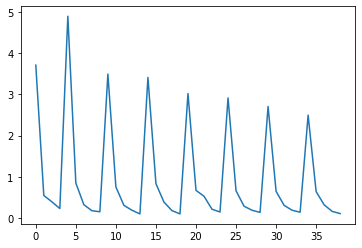

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history_callback.losses[1:])

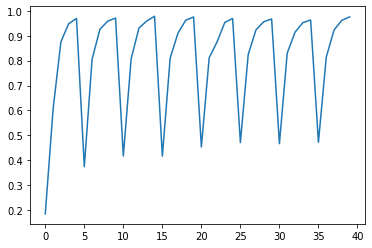

In [ ]:
plt.plot(loss_history_callback.acc)

In [ ]:
model.save('model.h5')

In [ ]:
model = keras.models.load_model('model.h5')

In [ ]:
paths_test = bts_paths['batch_9'] + bts_paths['batch_10']
y_test = bts_labels['batch_9'] + bts_labels['batch_10']
images = []

for path in paths_test:
  image = cv2.imread(path)
  image = cv2.resize(image, image_size)
  images.append(image)

x_test = np.asarray(images, dtype=np.float32)
y_test = np.asarray(y_test, dtype=int)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

109/109 [==============================] - 15s 136ms/step


In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)

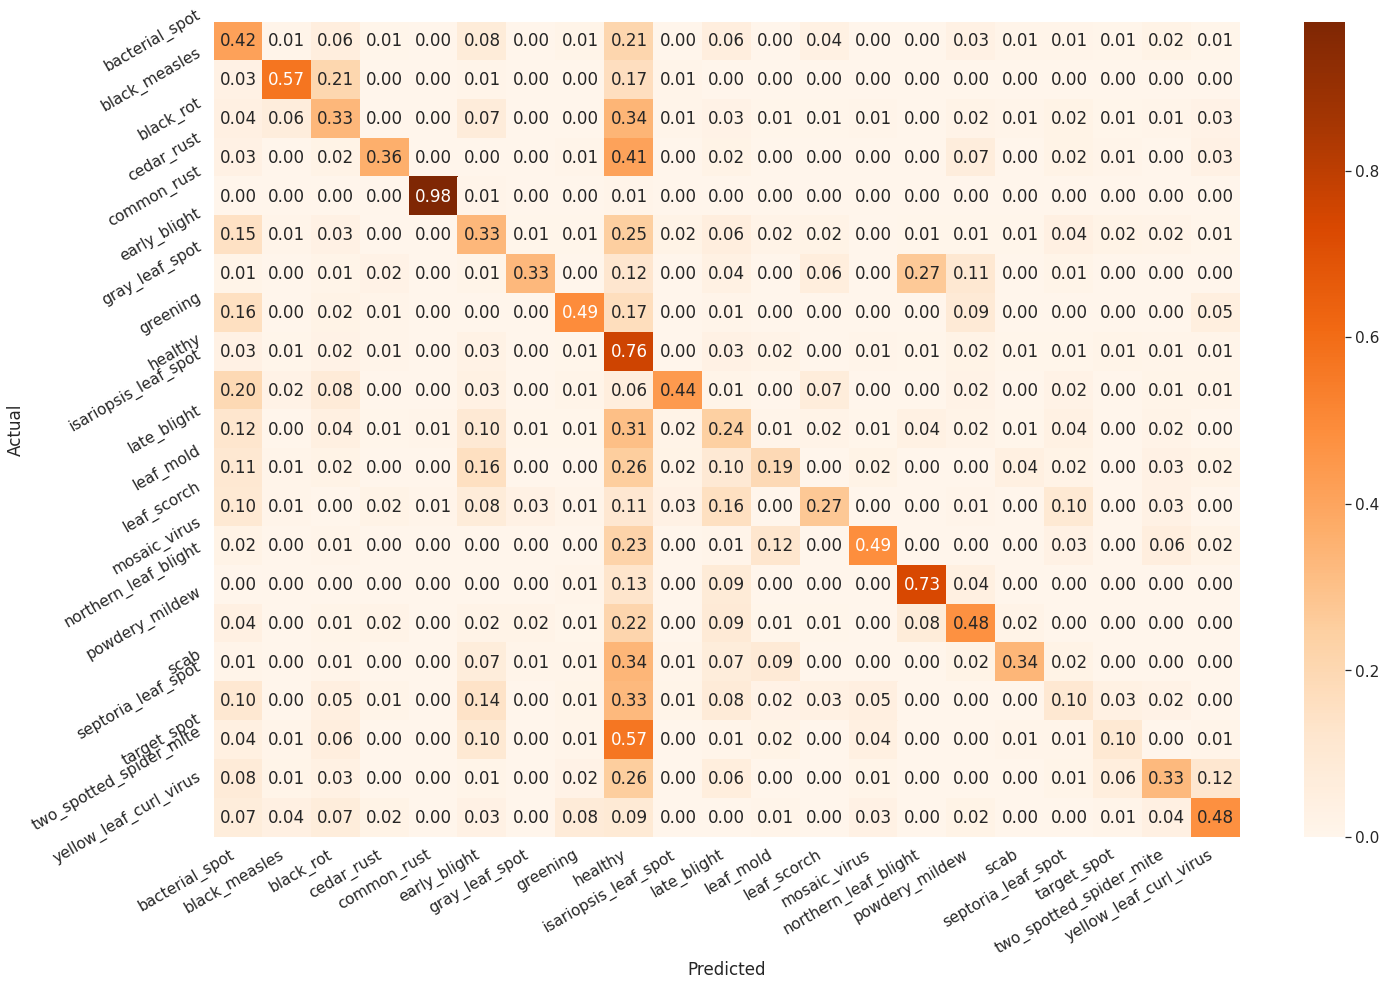

In [ ]:
cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(23,15))
sns.heatmap(cmn, annot=True, fmt='.2f',  cmap="Oranges")
sns.set(font_scale=1.4) # for label size
ax.xaxis.set_ticklabels(labels_for_enc.tolist())
ax.yaxis.set_ticklabels(labels_for_enc.tolist())
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.setp(ax.get_yticklabels(), rotation=30, ha='right')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
model.evaluate(x_test,y_test)

109/109 [==============================] - 15s 134ms/step - loss: 2.6245 - accuracy: 0.5108


[2.624518632888794, 0.5107604265213013]

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

109/109 [==============================] - 14s 132ms/step
              precision    recall  f1-score   support

           0       0.30      0.33      0.32       269
           1       0.62      0.50      0.55        96
           2       0.26      0.33      0.29       192
           3       0.51      0.35      0.42        88
           4       0.97      1.00      0.98        94
           5       0.38      0.46      0.42       192
           6       0.53      0.50      0.51        82
           7       0.64      0.65      0.65       100
           8       0.57      0.70      0.63      1104
           9       0.64      0.41      0.50        86
          10       0.22      0.31      0.26       188
          11       0.57      0.18      0.27        94
          12       0.48      0.28      0.36        88
          13       0.64      0.43      0.52        88
          14       0.52      0.77      0.62        94
          15       0.62      0.12      0.20       170
          16       0.52

In [ ]:
img =  cv2.imread('/content/TomatoEarlyBlight4.JPG')
img_resized = cv2.resize(img, image_size) 
img_array = img_resized[np.newaxis,:]
prediction = np.argmax(model.predict(img_array), axis=1)

1/1 [==============================] - 0s 121ms/step


Model prediction for the image is:  black_measles


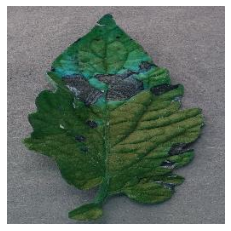

In [ ]:
for key in encode:
  if encode[key] == prediction:
    result = key

print("Model prediction for the image is: ", result)

pyplot.imshow(img)
pyplot.axis("off")
pyplot.show()